# Transmission matrix 
## acquisition, calculation and phase conjugation

### Phase shift interferometry (4-step)
this method can be used to measure the complext field of an interference pattern and it actually removes the mean amplitude term from the equation.


The light intensity measured on the camera is:

$$I_{\rm{camera}} = |e^{ia}E_{\rm{ref}}+E_{\rm{(x,y)}}|^2, $$

$E_{\rm{ref}}$ is the non-modulated part of the beam which acts as a local oscillator, 

$E_{\rm{(x, y)}}$ is the SML-modulated part of the beam,

$a$ is the phase which in this case will take four values: $0, \pi, \pi/2, 3\pi/2$. Therefore four each SLM pattern, four measurements will be carried out. 

The complex field is found to be:

$$E_{\rm{(x,y)}} =\frac{1}{E_{\rm{ref}}} \Bigg( \frac{I_0 - I_\pi}{4} + i \frac{I_{3\pi/2} - I_{\pi/2}}{4}\Bigg)$$



 On the pixel $j$ of the camera one gets the following field:
 
$$ \frac{I_0^j - I_\pi^j}{4} + i \frac{I_{3\pi/2}^j - I_{\pi/2}^j}{4} = \overline{s}^j \sum_i h^{ij} E_{\rm{in}}^i, $$

where

i: pixel on the slm

j: pixel on the camera

And the observed transmission matrix is:

$$ h_{ij}^{\rm{obs}} =  \frac{I_0^j - I_\pi^j}{4} + i \frac{I_{3\pi/2}^j - I_{\pi/2}^j}{4}. $$

### Effect of referecence beam and normalization
The observed transmission matrix has is affected by the reference beam. It has been shown that for a homogenous laser beam at the input of the SLM, this effect is statit at the output pixels; it is the same at a given pixel (see Popoff PhD). Therefore this effect can be reduced on the observed matrix by normalizing the latter by the standard deviation on a camera pixel, calculated for all the input vectors:

$$h_{ij}^{\rm{filtered}} = \frac{h_{ij}^{\rm{obs}}}{\sqrt{\langle|h_{ij}^{\rm{obs}}|^2\rangle}_i}$$, 

where $\sqrt{\langle|h_{ij}^{\rm{obs}}|^2\rangle}_i$ is the standard deviation. 

### Basis change
The filtered transmission matrix $h_{ij}^{\rm{filtered}}$ gives the relationship between and hadamard vector and the camera pixels. What we need in the end is a transmission matrix that gives the relationship between a SLM pixel and the camera pixels. 

For this, a basis change (from the hadamard basis to the canonical one) is needed to find the real transmission matrix:

$$H^{\rm{can}} = H_{\rm{ij}}^{\rm{had}} \times \mathcal{H}, $$

$$H^{\rm{can}} = H_{\rm{ij}}^{\rm{had}} \times \mathcal{H}, $$

with $\mathcal{H}$ the corresponding Hadamard matrix. 

#### import libraries

In [130]:
from slmOptim.optimization import transmission_matrix
from slmOptim.optimization import phase_conjugation, cost_functions
from slmOptim.optimization.init_experiment import InitExperiment

from slmOptim.zeluxPy import helper_functions as cam

from slmOptim.patternSLM import patterns as pt
from slmOptim.patternSLM.helper_functions import check

from slmPy import slmpy

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time, os
from matplotlib.colors import LogNorm
import time


#### set experiment parameters

In [4]:
# SLM-hadamard parameters

# SLM resolution 
resX, resY = (800, 600)

# the number of controlled segments on the SLM num_in ** 2
num_in = 32
# size of macropixels on slm 2 ** slm_macropix
slm_macropixel = 4

# 2pi value
slm_calib_px = 112

# Define observation window on camera
roi_size = 100
off = (0, 0)

# roi = cam.set_roi(roi_size, off)
# print(roi)

# Define camera macropixel, this is defined by the measured speckel grain
bins = 5

# Define camera acquisition parameters
exposure_time = 200
gain = 1
timeout= 100

# path to save raw data
path = '/home/optomeca/Documents/measurements'


#### initiliaze hardware: camera and slm

(20, 20)

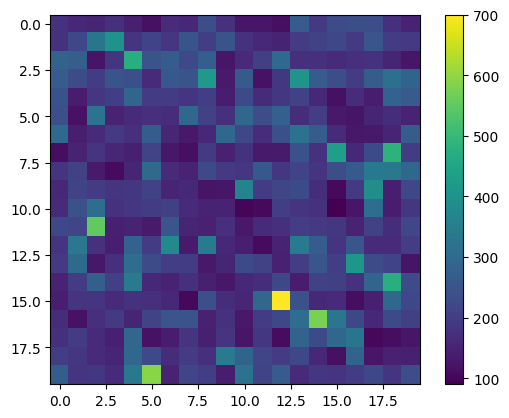

In [131]:
init.close_cam()

init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
# slm = init.init_slm()

frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)

plt.imshow(frame)
plt.colorbar()

frame.shape



#### just do some quick checks

Data transmitted


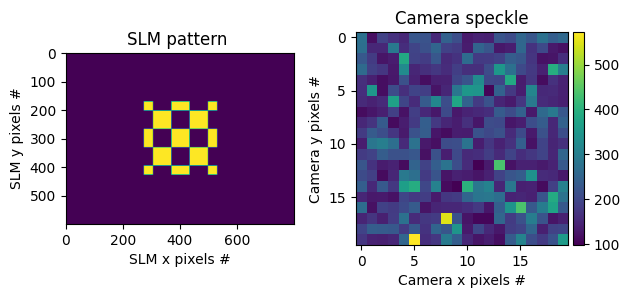

In [132]:
pattern, frame = check(slm, camera, 
                       num_in, (6, 6), slm_macropixel)

Data transmitted


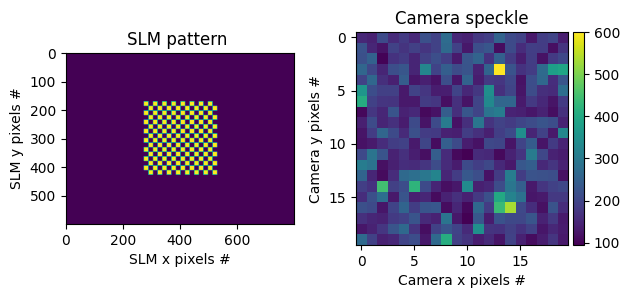

In [133]:
pattern, frame = check(slm, camera, 
                       num_in, (1, 1), slm_macropixel)

### 1. Perform TM measurement

In [ ]:
# create patterns - here hadamard patterns
pattern_loader = pt.HadamardPatternGenerator(num_in ** 2, slm_calib_px)

# instantiate tm
tm_raw = transmission_matrix.measTM(slm,
                                    camera,
                                    pattern_loader=pattern_loader,
                                    slm_macropixel_size=slm_macropixel,
                                    calib_px=slm_calib_px, 
                                    save_path=path,
                                    remote=True)

# run acquisition
time_delay = 0.1
frames = tm_raw.get2(time_delay)

# save raw data if you want
# tm_raw.save()


### 2. Calculate TM

In [ ]:
# filepath = '/home/optomeca/Documents/measurements/20230915-1354_tm_raw_data_ROI(770, 590, 867, 687)_Bins4_Order4_Mag5.pkl'

# with open(filepath, 'rb') as fp:
#     data = pickle.load(fp)

data = frames
# data = data[1]

# calculate TM
tr = transmission_matrix.calcTM(data)
tm_had, tm_fil, tm = tr.calc_plot_tm(figsize=(10, 3))

### 3. Phase conjugation -  Focusing

In [ ]:
init.close_cam()

bins=1
roi_size = 200
exposure_time = 200

init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()

In [ ]:
# define target
target_shape = (int(tm.shape[0] ** 0.5), int(tm.shape[0] ** 0.5))

tgt = phase_conjugation.Target(target_shape)
target_frame = tgt.square((2, 2), offset_x=0, offset_y=0, intensity=1)
target_frame = tgt.gauss(num=16, order=0, w0=1e-4, slm_calibration_px=112)




# phase conjugation - create mask
msk = phase_conjugation.InverseLight(target_frame, tm, slm_macropixel=slm_macropixel, calib_px=112)
phase_mask = msk.inverse_prop(conj=True)
inversion_operator_focus, inversion_operator_detection = msk.calc_inv_operator()
snr = msk.snr()
print(snr)
# plt.figure()

# plt.imshow(abs(inversion_operator))
# plt.colorbar()
# print(abs(inversion_operator))

# merge phase mask into an slm pattern
patternSLM = pt.Pattern(resX, resY)
focusing_mask = patternSLM.add_subpattern(phase_mask, gray = 10)

# apply mask
slm.sendArray(focusing_mask)


fig, axs = plt.subplots(1, 3, figsize=(10,10))

tar = axs[0].imshow(abs(target_frame))
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(tar, cax=cax)   

inv_foc = axs[1].imshow(abs(inversion_operator_focus))
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(inv_foc, cax=cax)   

inv_det = axs[2].imshow(abs(inversion_operator_detection))
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(inv_det, cax=cax)   

fig.tight_layout()

Error. Data not transmitted
Wrong image size?
Retrying
Data transmitted
Data transmitted


TypeError: Image data of dtype object cannot be converted to float

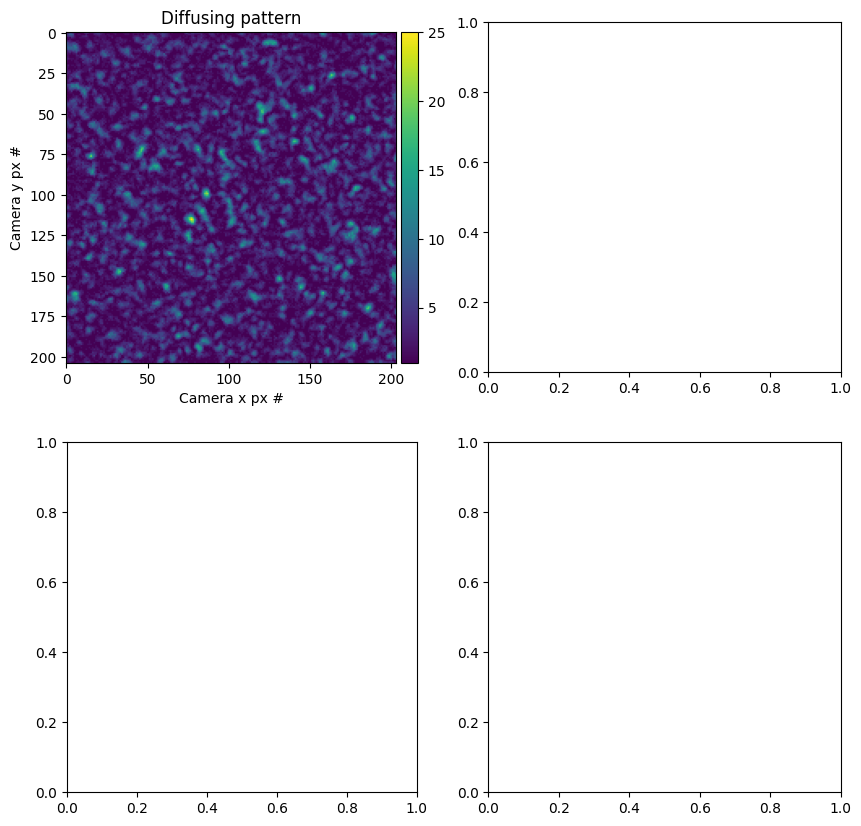

In [42]:


# apply mask
focusing_mask = patternSLM.add_subpattern(phase_mask, gray = 100)

slm.sendArray(focusing_mask)
time.sleep(0.2)

# get frame
frame = camera.get_pending_frame_or_null()
frame_focus = np.copy(frame.image_buffer)
profile_line = len(frame_focus) // 2 - 2

# set/get speckle
patSLM = pt.Pattern(resX, resY)
mirror = patSLM.mirror()
slm.sendArray(mirror)
time.sleep(.2)
frame = camera.get_pending_frame_or_null()
frame_speck = np.copy(frame.image_buffer)

# plot

fig, axs = plt.subplots(2, 2, figsize=(10,10))

speck = axs[0, 0].imshow(frame_speck)
axs[0, 0].set_title("Diffusing pattern")
axs[0, 0].set_xlabel("Camera x px #")
axs[0, 0].set_ylabel("Camera y px #")
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(speck, cax=cax)   

mask = axs[1, 0].imshow(mask)
axs[1, 0].set_title("Focus mask")
axs[1, 0].set_xlabel("SLM x px #")
axs[1, 0].set_ylabel("SLM y px #")
divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(mask, cax=cax)   

frame = axs[0, 1].imshow(frame_focus)
# frame = axs[0, 1].imshow(frame_focus)
# frame = axs[1].imshow(frame_focus)

axs[0, 1].set_title("Focusing")
axs[0, 1].set_xlabel("Camera x px #")
axs[0, 1].set_ylabel("Camera y px #")
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(frame, cax=cax)   

axs[1, 1].plot(frame_focus[profile_line][:])
axs[1, 1].set_box_aspect(1)
axs[1, 1].set_title("Focus profile")
axs[1, 1].set_xlabel("Camera x px #")
axs[1, 1].set_ylabel("Intensity (a.u.) #")

fig.tight_layout()

slm.sendArray(focusing_mask)

plt.savefig("256static.png", dpi=200, transparent=True)

# with open("256ΤΜfocusSNR300.pkl", 'wb') as fp:
#     pickle.dump((phase_mask, frame_focus), fp)

In [ ]:
#### Calculate signal to noise 

1.0331843521722415
1.7405510797633585 1018.0
584.872234912178


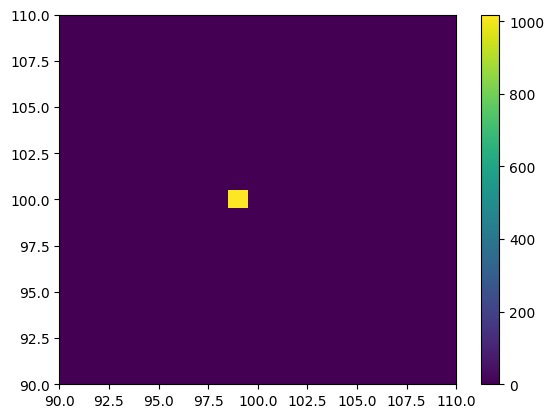

In [117]:
def signal2noise(frame, dark=1, mask_radius=8, mask_offset=(0, 0), intesity_only=False):
    """ Thank you S. Popoff
        Creates mask with a disk in the center and calculates the ratio of the
        pixel intensity in the disk to the pixel intensity outside the disk.
    """

    res = frame.shape
    off = mask_offset
    mask_center = [res[0] // 2 + off[0], res[1] // 2 + off[1]]
    
    max_idx = ndimage.maximum_position(frame)
    mask_center = [max_idx[0], max_idx[1]]
    
    
    Y, X = np.meshgrid(np.arange(res[0]),np.arange(res[1]))

    # We generate a mask representing the disk we want to intensity to be concentrated in
    mask = (X - mask_center[0]) ** 2 + (Y - mask_center[1]) ** 2 < mask_radius ** 2

    if intesity_only:
        cost = np.sum((frame) * mask)
    else:
        signal = np.sum((frame) * mask) / np.sum(mask)
        noise = np.sum((frame) * (1. - mask)) / np.sum(1. - mask) - dark
        snr = signal / noise
    return snr, mask   



# get camera dark noise
frame_noise = camera.get_pending_frame_or_null()
frame_noise = np.copy(frame_noise.image_buffer)

# calculate dark noise mean
dark_noise = frame_noise.mean()

snr, mask = signal2noise(frame_focus, dark_noise, mask_radius=1)

plt.imshow(frame_focus * mask, aspect='auto')
plt.colorbar()
plt.xlim(90, 110)
plt.ylim(90, 110)

print(snr)

### Script 

Uploading pattern vectors:   0%|          | 0/16 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

Iterating through camera pixels: 0it [00:00, ?it/s]

Data transmitted

Data transmitted



Uploading pattern vectors:   0%|          | 0/64 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

/home/optomeca/Projects/slmOptim/optimization/transmission_matrix.py:149: UserWarning: Pixel saturation: 1003.
  warnings.warn("Pixel saturation: {}.".format(max_level), UserWarning)


Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

Iterating through camera pixels: 0it [00:00, ?it/s]

Data transmitted

Data transmitted



Uploading pattern vectors:   0%|          | 0/256 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

/home/optomeca/Projects/slmOptim/optimization/transmission_matrix.py:149: UserWarning: Pixel saturation: 1023.
  warnings.warn("Pixel saturation: {}.".format(max_level), UserWarning)


Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

Iterating through camera pixels: 0it [00:00, ?it/s]

Data transmitted

Data transmitted



Uploading pattern vectors:   0%|          | 0/1024 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

Iterating through camera pixels: 0it [00:00, ?it/s]

Data transmitted

Data transmitted



Uploading pattern vectors:   0%|          | 0/4096 [00:00<?, ?it/s]

Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

/home/optomeca/Projects/slmOptim/optimization/transmission_matrix.py:149: UserWarning: Pixel saturation: 1013.
  warnings.warn("Pixel saturation: {}.".format(max_level), UserWarning)


Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitted
Data transmitt

Iterating through camera pixels: 0it [00:00, ?it/s]

Data transmitted

Data transmitted


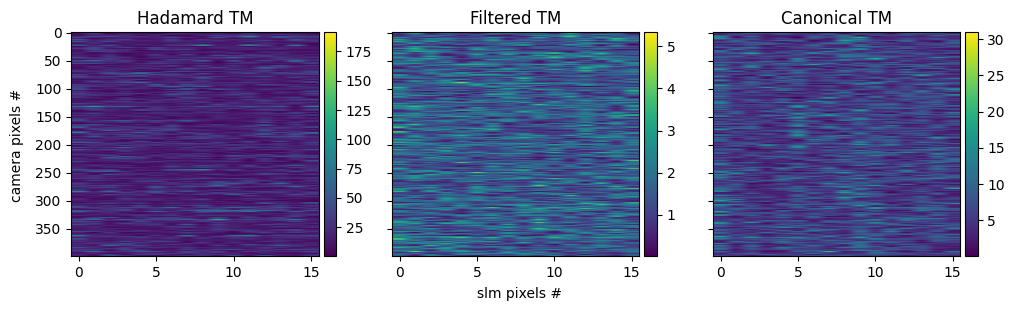

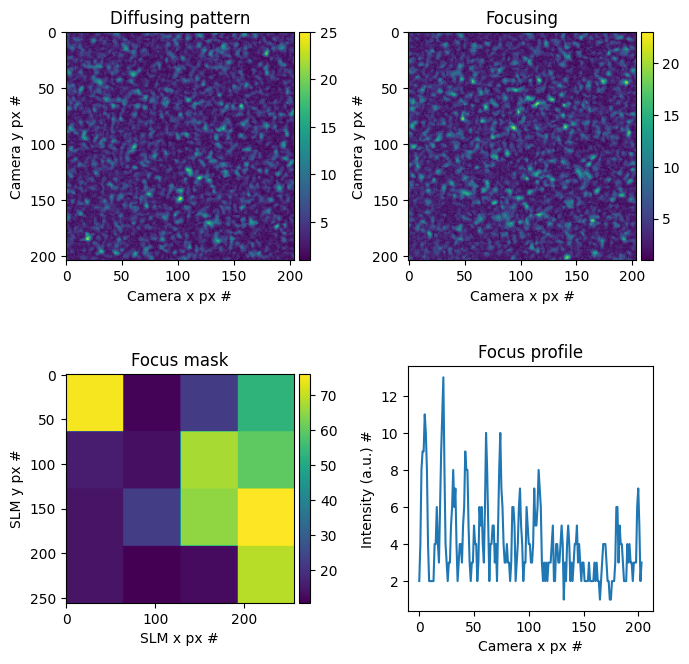

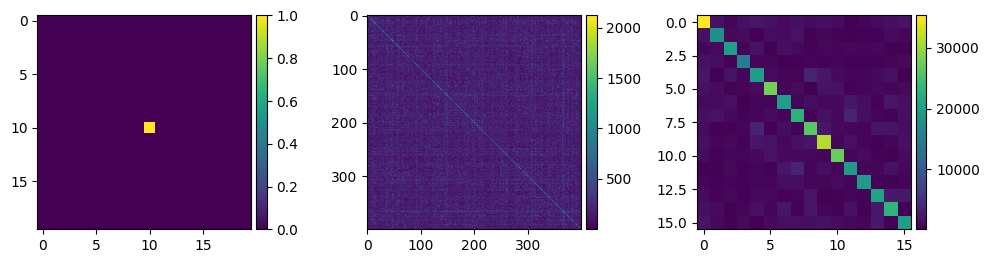

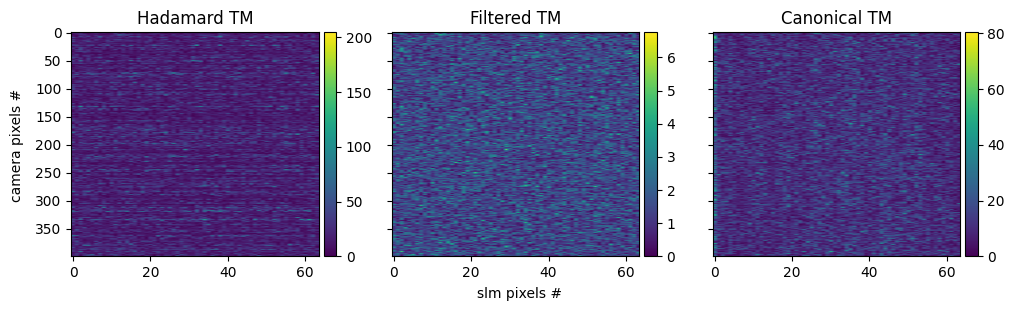

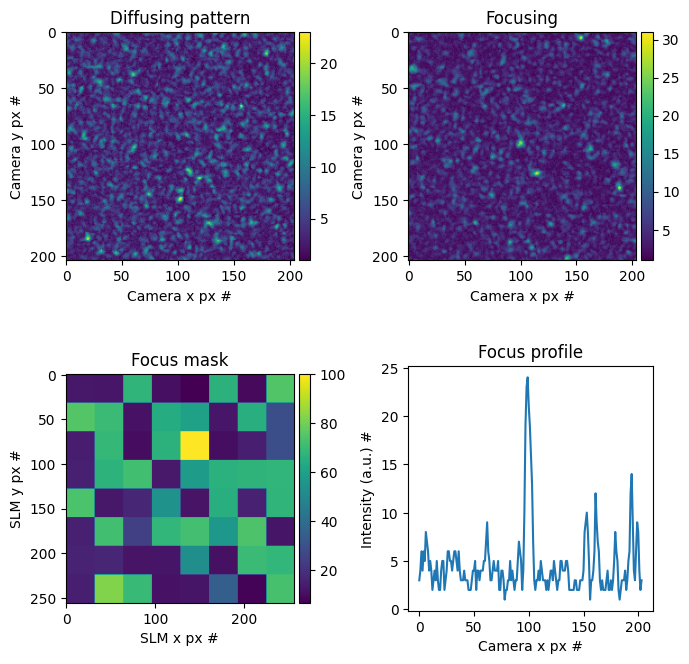

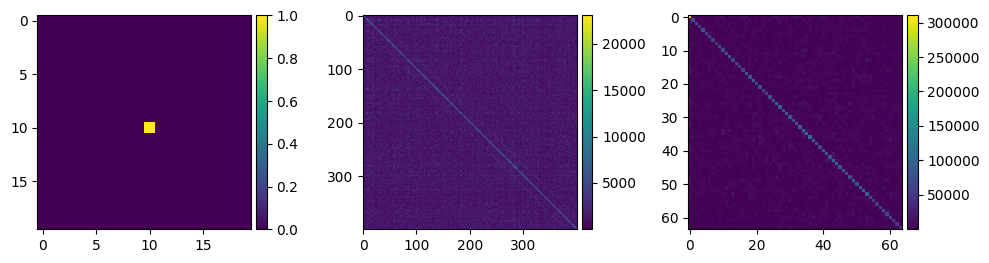

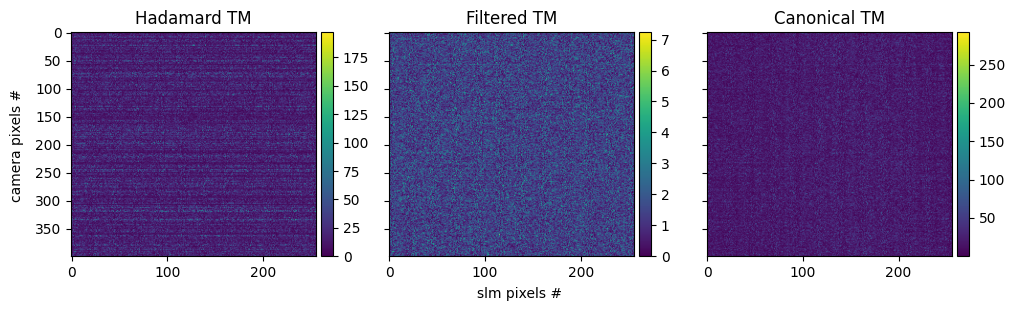

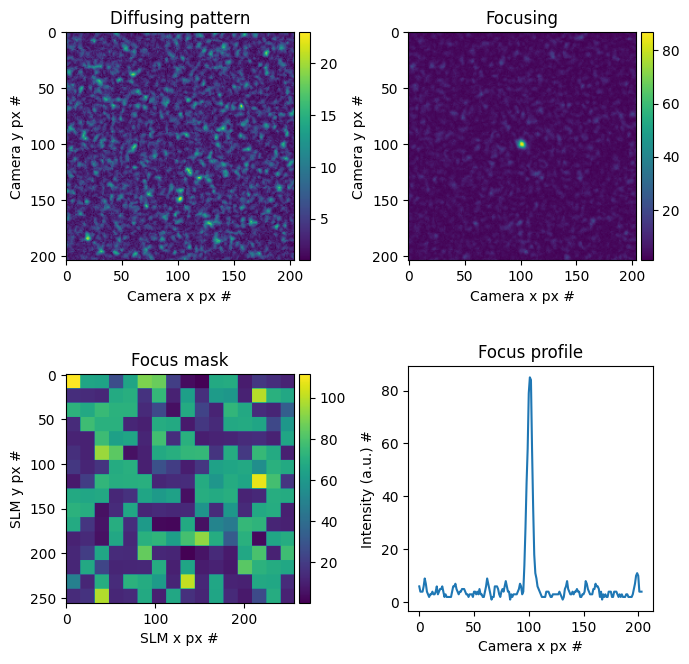

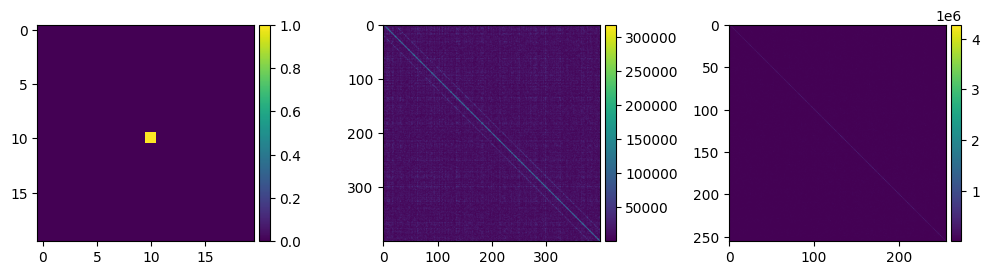

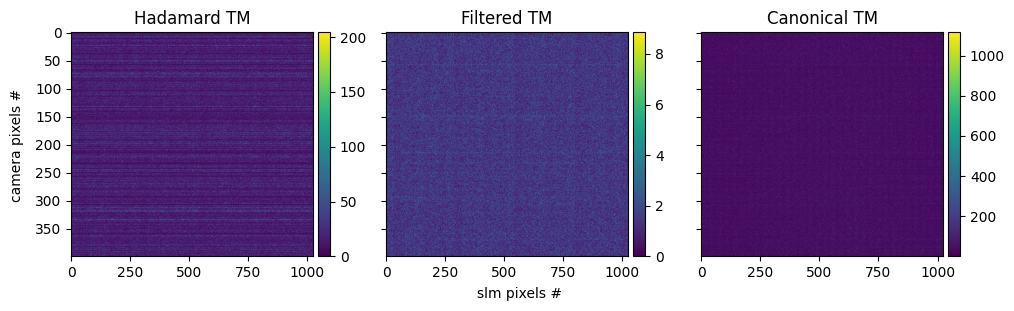

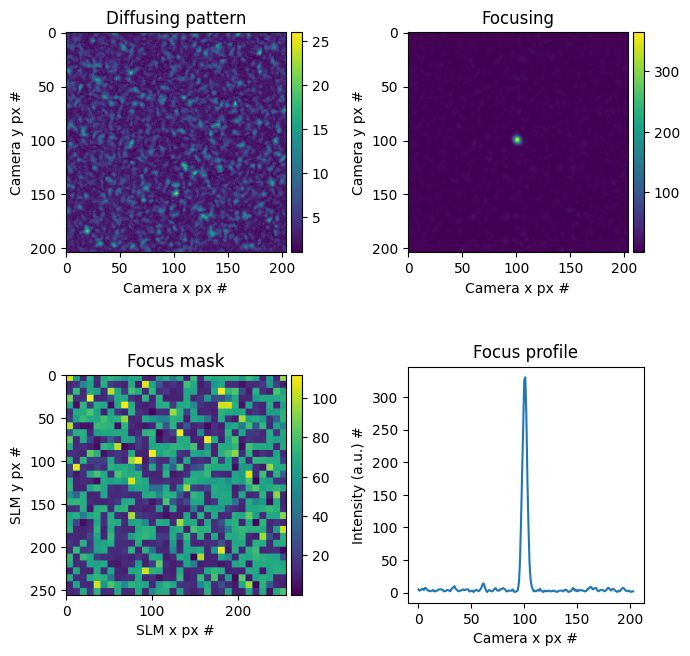

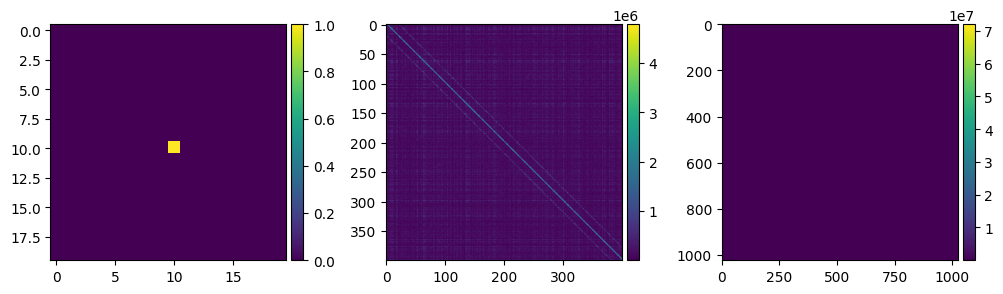

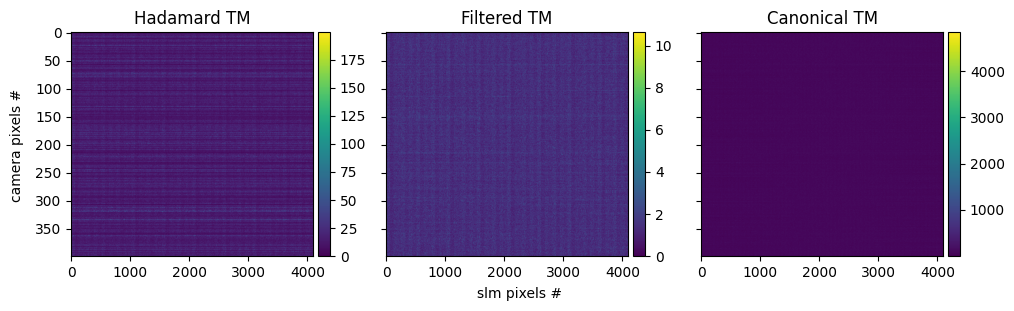

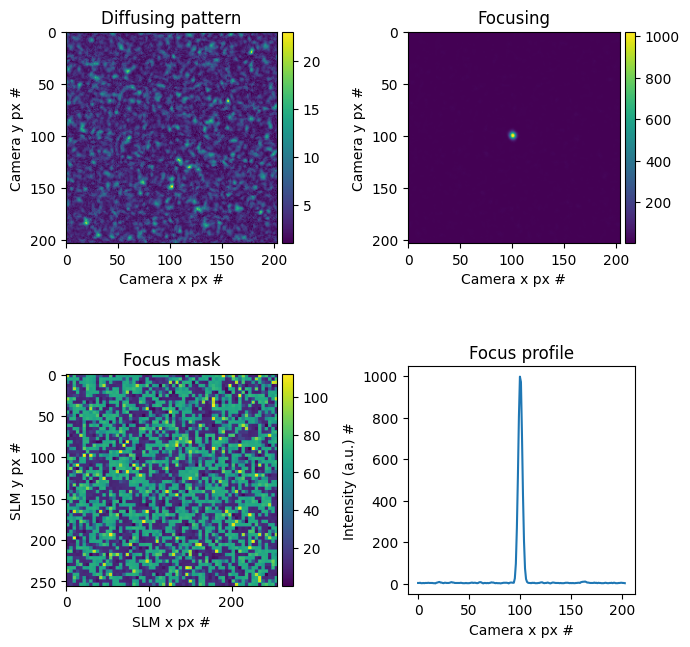

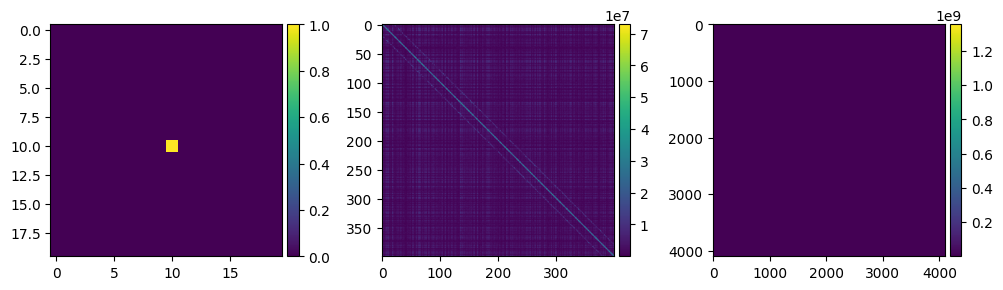

In [157]:
def reset_camera(init, bins, roi_size, time=200):
    
    init.close_cam()
    exposure_time = time
    init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
    camera = init.init_cam()
    return camera, init

def measure_tm(camera, num_in):
    
    # create patterns to load
    pattern_loader = pt.HadamardPatternGenerator(num_in ** 2, slm_calib_px)
    
    # instantiate tm
    tm_raw = transmission_matrix.measTM(slm,
                                    camera,
                                    pattern_loader=pattern_loader,
                                    slm_macropixel_size=slm_macropixel,
                                    calib_px=slm_calib_px, 
                                    save_path=path,
                                    remote=True)

    # run acquisition
    time_delay = 0.1
    frames = tm_raw.get2(time_delay)
    tm_raw.save()
    
    # calculater TM
    tr = transmission_matrix.calcTM(frames)
    tm_had, tm_fil, tm = tr.calc_plot_tm(figsize=(10, 3))   
    
    return tm

def conjugate(tm):
    
    # define target
    target_shape = (int(tm.shape[0] ** 0.5), int(tm.shape[0] ** 0.5))

    tgt = phase_conjugation.Target(target_shape)
    target_frame = tgt.gauss(num=16, order=0, w0=1e-4, slm_calibration_px=112)

    # phase conjugation - create mask
    msk = phase_conjugation.InverseLight(target_frame, tm, slm_macropixel=slm_macropixel, calib_px=112)
    phase_mask = msk.inverse_prop(conj=True)
    
    # get inversion operator and calculate snr
    inversion_operator_focus, inversion_operator_detection = msk.calc_inv_operator()
    snr = msk.snr()   
    
    return phase_mask, snr, target_frame, inversion_operator_focus, inversion_operator_detection
    
def focus(phase_mask):
    # merge phase mask into an slm pattern
    patternSLM = pt.Pattern(resX, resY)
    focusing_mask = patternSLM.add_subpattern(phase_mask, gray = 10)
    slm.sendArray(focusing_mask)
    return focusing_mask 

def set_mirror():
    patSLM = pt.Pattern(resX, resY)
    mirror = patSLM.mirror()
    slm.sendArray(mirror)
    time.sleep(.2)
    
def get_frame(camera):
    frame = camera.get_pending_frame_or_null()
    frame = np.copy(frame.image_buffer)
    
    return frame
    
def plot(phase_mask, frame_speck, frame_focus, off=0):
    fig, axs = plt.subplots(2, 2, figsize=(7,7))

    speck = axs[0, 0].imshow(frame_speck)
    axs[0, 0].set_title("Diffusing pattern")
    axs[0, 0].set_xlabel("Camera x px #")
    axs[0, 0].set_ylabel("Camera y px #")
    divider = make_axes_locatable(axs[0, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(speck, cax=cax)   

    mask = axs[1, 0].imshow(phase_mask)
    axs[1, 0].set_title("Focus mask")
    axs[1, 0].set_xlabel("SLM x px #")
    axs[1, 0].set_ylabel("SLM y px #")
    divider = make_axes_locatable(axs[1, 0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(mask, cax=cax)   

    frame = axs[0, 1].imshow(frame_focus)
    # frame = axs[0, 1].imshow(frame_focus)
    # frame = axs[1].imshow(frame_focus)

    axs[0, 1].set_title("Focusing")
    axs[0, 1].set_xlabel("Camera x px #")
    axs[0, 1].set_ylabel("Camera y px #")
    divider = make_axes_locatable(axs[0, 1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(frame, cax=cax)   

    profile_line = len(frame_focus) // 2 + off
    axs[1, 1].plot(frame_focus[profile_line][:])
    axs[1, 1].set_box_aspect(1)
    axs[1, 1].set_title("Focus profile")
    axs[1, 1].set_xlabel("Camera x px #")
    axs[1, 1].set_ylabel("Intensity (a.u.) #")

    fig.tight_layout()
    
    timestr = time.strftime("%Y%m%d-%H%M")
    filename = "{}_focus_num_in{}_slm_macro{}.png".format(timestr, num_in, slm_macropixel)
    filepath = os.path.join(path, filename)
    fig.savefig(filepath, dpi=200, transparent=True)

    
def plot2(target_frame, inversion_operator_focus, inversion_operator_detection):
    fig2, axs = plt.subplots(1, 3, figsize=(10,10))

    tar = axs[0].imshow(abs(target_frame))
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig2.colorbar(tar, cax=cax)   

    inv_foc = axs[1].imshow(abs(inversion_operator_focus))
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig2.colorbar(inv_foc, cax=cax)   

    inv_det = axs[2].imshow(abs(inversion_operator_detection))
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig2.colorbar(inv_det, cax=cax)   

    fig2.tight_layout()
    
    timestr = time.strftime("%Y%m%d-%H%M")
    filename = "{}_operators_num_in{}_slm_macro{}.png".format(timestr, num_in, slm_macropixel)
    filepath = os.path.join(path, filename)
    fig2.savefig(filepath, dpi=200, transparent=True)
    
def signal2noise(frame, dark=1.033, mask_radius=8):
    """ Thank you S. Popoff
        Creates mask with a disk in the center and calculates the ratio of the
        pixel intensity in the disk to the pixel intensity outside the disk.
    """

    res = frame.shape
    
    max_idx = ndimage.maximum_position(frame)
    mask_center = [max_idx[0], max_idx[1]]
    
    
    Y, X = np.meshgrid(np.arange(res[0]),np.arange(res[1]))

    # We generate a mask representing the disk we want to intensity to be concentrated in
    mask = (X - mask_center[0]) ** 2 + (Y - mask_center[1]) ** 2 < mask_radius ** 2

    signal = np.sum((frame) * mask) / np.sum(mask)
    noise = np.sum((frame) * (1. - mask)) / np.sum(1. - mask) - dark
    snr = signal / noise

    return snr, mask
    
if __name__ ==  "__main__":
    
    n = [4, 8, 16, 32, 64]
    m = [7, 6, 5, 4, 3]
    
    tms=[]
    snrs = []
    masks = []
    frames = []
    
    for num_in, slm_macropixel in zip(n, m):
        
        camera, init = reset_camera(init, 5, 100, 200)
        tm = measure_tm(camera, num_in)
        mask, snr, target_frame, inversion_operator_focus, inversion_operator_detection  = conjugate(tm)
        focusing_mask = focus(mask)
        camera, init = reset_camera(init, 1, 200, 100)
        frame_focus = get_frame(camera)
        set_mirror()
        frame_speck = get_frame(camera)
        
        plot(mask, frame_speck, frame_focus, -1)
        plot2(target_frame, inversion_operator_focus, inversion_operator_detection)
        
        snr, maks = signal2noise(frame_focus, dark=1.033, mask_radius=1)
        tms.append(tm)
        masks.append(mask)
        frames.append(frame_focus)   
        snrs.append(snr)

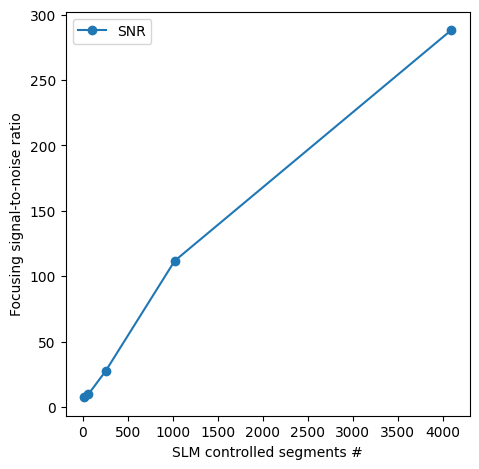

In [330]:
fig, ax = plt.subplots()
x = [16, 64, 256, 1024, 4096]
line, = ax.plot(x, snrs, 'o-', label='SNR')
ax.legend()


ax.set_xlabel('SLM controlled segments #')
ax.set_ylabel('Focusing signal-to-noise ratio')
ax.set_box_aspect(1)

plt.tight_layout()

plt.savefig("TM_SNRs.png", dpi=200, transparent=True)

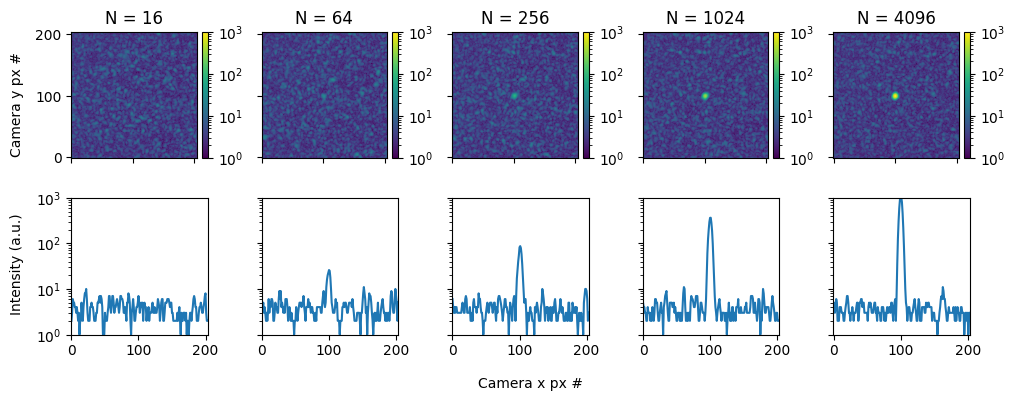

In [324]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey='row')

order = [2, 3, 4, 5, 6]

for ax, idx in zip(axs.ravel(), range(10)):
    if idx < 5:
        im = ax.imshow(frames[idx], norm=LogNorm(vmin=1, vmax=1000), origin='lower')
        
        N = 2 ** order[idx]
        title = 'N = ' + str(N ** 2)
        ax.set_title(title)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)  
        
    else:
        ax.semilogy(frames[idx - 5][100]) 
        ax.set_ylim([1, 1000])
        ax.set_box_aspect(1)

fig.text(0.51, -0.01, 'Camera x px #', ha='center')
fig.text(-0.01, 0.7, 'Camera y px #', va='center', rotation='vertical')
fig.text(-0.01, 0.3, 'Intensity (a.u.)', va='center', rotation='vertical')



fig.tight_layout(h_pad=.001, w_pad=1)

plt.savefig("TM_focus_vs_N.png", dpi=200, transparent=True)



In [1]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey='row')

order = [2, 3, 4, 5, 6]

for ax, idx in zip(axs.ravel(), range(10)):
    if idx < 5:
        im = ax.imshow(frames[idx], origin='lower')
        
        N = 2 ** order[idx]
        title = 'N = ' + str(N ** 2)
        ax.set_title(title)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im, cax=cax)  
        
    else:
        ax.plot(frames[idx - 5][100]) 
        ax.set_ylim([1, 1000])
        ax.set_box_aspect(1)

fig.text(0.51, -0.01, 'Camera x px #', ha='center')
fig.text(-0.01, 0.7, 'Camera y px #', va='center', rotation='vertical')
fig.text(-0.01, 0.3, 'Intensity (a.u.)', va='center', rotation='vertical')



fig.tight_layout(h_pad=.001, w_pad=1)

plt.savefig("TM_focus_vs_N_lin.png", dpi=200, transparent=True)



NameError: name 'plt' is not defined